### Time Travel
In a typical chat bot workflow, the user interacts with the bot 1 ore more times to accomplish a task.
Ini the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and control future response.

But what if you want to let your user start from a previous resoponse and "branch off" to 
explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's
work to fix some mistakes or try different startegy (common in applications like autonomous software engineeer)?

You can create both of these expreiences and more using LangGraph's built-in "time travel" functionlity.

In this section, you will "rewind" your graph by fetching a checkpoing using the graph's `get_state_history` method. You can then resume execution at this previous point in time.


### Let'use the simple chatbot with tools

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# Set google api key
_set_env("DASHSCOPE_API_KEY")
# Set tavily api key
_set_env("TAVILY_API_KEY")

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool]
# Set up the Tongyi model
llm = ChatTongyi(
    model="qwen-plus",
    temperature=0.3,
    api_key=os.environ["DASHSCOPE_API_KEY"]
)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### Draw graph

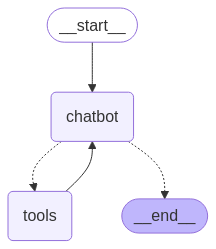

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Let's have our graph take a couple steps. Every step will be checkpoints in its state history

In [18]:
config = {"configurable": {"thread_id": "2"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_e3f358e3c464484093c56d)
 Call ID: call_e3f358e3c464484093c56d
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its com

In [19]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful,. Maybe I'll"
                    "Build an autonomous agent with it!"
                ),
            },
        ], 
    },
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful,. Maybe I'llBuild an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can indeed be a rewarding experience. Here are some steps and tips to help you get started:

1. **Understand the Basics**: Make sure you have a solid understanding of LangGraph's core concepts, such as nodes, edges, and how they interact within the graph structure.

2. **Define Your Agent's Purpose**: Clearly outline what tasks or problems your autonomous agent will address. This will guide the design and implementation process.

3. **Set Up Your Environment**: Ensure that you have all necessary dependencies installed, including Python and any required libraries (LangGraph, LangChain, etc.).

4. **Design the Workflow**: Sketch out the workflow for your agent using directed graphs.

### Replay
Now that we'vew had the agent take couple steps, we can `replay` the full state history to see everything that occurred.

In [22]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitraily selecting a specific state based on the number of chat messages in the state.
        to_replay = state
        

Num messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


### Resuming from this point should call the `action` node next.

In [23]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f01ba36-81d7-6bee-8006-b6c98b35b84c'}}


<b>Notice</b> that the checkpoint's config(`to_replay.config`) contains a `checkpoint_id` `timestamp`, Providing this `checkpoint_id`
value tell Langgraph's checkpointer to load the state from that moment in time. Let's try it below:

In [24]:
# The `checkpoint_id` in the `to_replay_config` corresponds to state we've presisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can indeed be a rewarding experience. Here are some steps and tips to help you get started:

1. **Understand the Basics**: Make sure you have a solid understanding of LangGraph's core concepts, such as nodes, edges, and how they interact within the graph structure.

2. **Define Your Agent's Purpose**: Clearly outline what tasks or problems your autonomous agent will address. This will guide the design and implementation process.

3. **Set Up Your Environment**: Ensure that you have all necessary dependencies installed, including Python and any required libraries (LangGraph, LangChain, etc.).

4. **Design the Workflow**: Sketch out the workflow for your agent using directed graphs. Decide on the actions (nodes) and transitions (edges) needed for your application.

5. **Implement the Agent**: Start coding your agent by definin

<b>Notice</b> That the graph resumed execution from the `action` node. You can tell this is the case since the first
value printed above is the response from our search engine tool.